In [ ]:
!pip install torch torchvision segmentation-models-pytorch albumentations opencv-python matplotlib tqdm -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 2.4 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [6]:
import os, random, shutil
from glob import glob

IMG_DIR  = "/content/drive/MyDrive/FloodMappingData/Images"
MASK_DIR = "/content/drive/MyDrive/FloodMappingData/Masks"
OUT_DIR  = "/content/data_split"

for split in ["train","val","test"]:
    for sub in ["images","masks"]:
        os.makedirs(os.path.join(OUT_DIR, split, sub), exist_ok=True)

images = sorted([os.path.basename(p) for p in glob(os.path.join(IMG_DIR, "*.png"))])
paired = [f for f in images if os.path.exists(os.path.join(MASK_DIR, f))]

random.seed(42)
random.shuffle(paired)
n = len(paired)
n_train, n_val = int(0.8*n), int(0.1*n)
splits = {
    "train": paired[:n_train],
    "val": paired[n_train:n_train+n_val],
    "test": paired[n_train+n_val:]
}

for split, files in splits.items():
    for f in files:
        shutil.copy(os.path.join(IMG_DIR, f),  os.path.join(OUT_DIR, split, "images", f))
        shutil.copy(os.path.join(MASK_DIR, f), os.path.join(OUT_DIR, split, "masks", f))

print({k: len(v) for k,v in splits.items()})


{'train': 2721, 'val': 340, 'test': 341}


In [7]:
import cv2, torch, numpy as np, albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
import os # Import os module

IMG_SIZE = 256

train_tfms = A.Compose([
    A.Resize(IMG_SIZE,IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2()
])
val_tfms = A.Compose([
    A.Resize(IMG_SIZE,IMG_SIZE),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2()
])

class SegDataset(Dataset):
    def __init__(self,img_dir,mask_dir,tfm=None):
        self.img_dir, self.mask_dir, self.tfm = img_dir, mask_dir, tfm
        self.imgs = []
        for f in sorted(os.listdir(img_dir)):
            img_path = os.path.join(img_dir, f)
            mask_path = os.path.join(mask_dir, f)
            # Check if both image and mask files exist and can be read
            if os.path.exists(mask_path):
                try:
                    img = cv2.imread(img_path)
                    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                    if img is not None and mask is not None:
                        self.imgs.append(f)
                    else:
                        print(f"Warning: Skipping {f} due to read error.")
                except Exception as e:
                    print(f"Warning: Skipping {f} due to error: {e}")


    def __len__(self): return len(self.imgs)
    def __getitem__(self,idx):
        img = cv2.cvtColor(cv2.imread(os.path.join(self.img_dir,self.imgs[idx])),cv2.COLOR_BGR2RGB)
        mask= cv2.imread(os.path.join(self.mask_dir,self.imgs[idx]),cv2.IMREAD_GRAYSCALE)
        mask = (mask>127).astype("float32")
        if self.tfm:
            aug=self.tfm(image=img,mask=mask); img,mask=aug["image"],aug["mask"]
        return img, mask.unsqueeze(0)

BASE="/content/data_split"
train_ds=SegDataset(f"{BASE}/train/images",f"{BASE}/train/masks",train_tfms)
val_ds  =SegDataset(f"{BASE}/val/images",  f"{BASE}/val/masks",  val_tfms)
test_ds =SegDataset(f"{BASE}/test/images", f"{BASE}/test/masks", val_tfms)

train_dl=DataLoader(train_ds,batch_size=8,shuffle=True,num_workers=2,pin_memory=True)
val_dl  =DataLoader(val_ds,batch_size=8,shuffle=False,num_workers=2,pin_memory=True)

In [8]:
import segmentation_models_pytorch as smp
import torch.nn as nn

device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:",device)

model=smp.Unet(encoder_name="resnet34",encoder_weights="imagenet",
               in_channels=3,classes=1).to(device)

bce = nn.BCEWithLogitsLoss()
dice= smp.losses.DiceLoss(mode='binary')
def loss_fn(pred,y): return bce(pred,y)+dice(pred,y)

opt=torch.optim.Adam(model.parameters(),lr=1e-4)

Device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

In [ ]:
from tqdm import tqdm
import torch

#Intersection over Union
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor, threshold=0.5):
    preds = (torch.sigmoid(outputs) > threshold).int()
    labels = labels.int()

    intersection = (preds & labels).float().sum((1, 2))
    union = (preds | labels).float().sum((1, 2))

    iou = (intersection + 1e-6) / (union + 1e-6)

    return iou.mean()


# Training and validation loop
best_val_iou = 0.0
num_epochs = 10

# Lists to store metrics for plotting
train_losses = []
val_losses = []
val_ious = []

for epoch in range(num_epochs):
    #Training
    model.train()
    total_train_loss = 0.0

    train_progress_bar = tqdm(train_dl, desc=f"Epoch {epoch+1}/{num_epochs} [Training]")
    for x, y in train_progress_bar:
        x, y = x.to(device), y.to(device)

        opt.zero_grad()
        pred = model(x)
        loss = loss_fn(pred, y)
        loss.backward()
        opt.step()

        total_train_loss += loss.item()
        # Update progress bar with live loss
        train_progress_bar.set_postfix(loss=total_train_loss / len(train_progress_bar))

    avg_train_loss = total_train_loss / len(train_dl)
    train_losses.append(avg_train_loss) # Store training loss

    #Validation
    model.eval()
    total_val_loss = 0.0
    total_val_iou = 0.0

    val_progress_bar = tqdm(val_dl, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]")
    with torch.no_grad():
        for x, y in val_progress_bar:
            x, y = x.to(device), y.to(device)

            pred = model(x)
            loss = loss_fn(pred, y)
            iou = iou_pytorch(pred, y)

            total_val_loss += loss.item()
            total_val_iou += iou.item()

            # Update progress bar with live metrics
            val_progress_bar.set_postfix(
                val_loss=total_val_loss / len(val_progress_bar),
                val_iou=total_val_iou / len(val_progress_bar)
            )

    avg_val_loss = total_val_loss / len(val_dl)
    avg_val_iou = total_val_iou / len(val_dl)
    val_losses.append(avg_val_loss)
    val_ious.append(avg_val_iou) 

    print(f"Epoch {epoch+1}/{num_epochs} -> Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val IoU: {avg_val_iou:.4f}")


    if avg_val_iou > best_val_iou:
        best_val_iou = avg_val_iou
        torch.save(model.state_dict(), "best_unet.pth")
        print(f"Model Saved! New best validation IoU: {best_val_iou:.4f}")

print("\n--- Training Complete! ---")

Epoch 1/10 [Validation]: 100%|██████████| 43/43 [00:05<00:00,  8.36it/s, val_iou=0.78, val_loss=0.381]


Epoch 1/10 -> Train Loss: 0.5525 | Val Loss: 0.3809 | Val IoU: 0.7799
Model Saved! New best validation IoU: 0.7799


Epoch 2/10 [Validation]: 100%|██████████| 43/43 [00:05<00:00,  8.47it/s, val_iou=0.797, val_loss=0.313]


Epoch 2/10 -> Train Loss: 0.3511 | Val Loss: 0.3131 | Val IoU: 0.7973
Model Saved! New best validation IoU: 0.7973


Epoch 3/10 [Validation]: 100%|██████████| 43/43 [00:05<00:00,  8.52it/s, val_iou=0.825, val_loss=0.255]


Epoch 3/10 -> Train Loss: 0.2909 | Val Loss: 0.2550 | Val IoU: 0.8255
Model Saved! New best validation IoU: 0.8255


Epoch 4/10 [Validation]: 100%|██████████| 43/43 [00:05<00:00,  8.02it/s, val_iou=0.838, val_loss=0.229]


Epoch 4/10 -> Train Loss: 0.2572 | Val Loss: 0.2292 | Val IoU: 0.8382
Model Saved! New best validation IoU: 0.8382


Epoch 5/10 [Validation]: 100%|██████████| 43/43 [00:05<00:00,  7.64it/s, val_iou=0.849, val_loss=0.215]


Epoch 5/10 -> Train Loss: 0.2291 | Val Loss: 0.2149 | Val IoU: 0.8487
Model Saved! New best validation IoU: 0.8487


Epoch 6/10 [Validation]: 100%|██████████| 43/43 [00:05<00:00,  8.15it/s, val_iou=0.854, val_loss=0.205]


Epoch 6/10 -> Train Loss: 0.2166 | Val Loss: 0.2049 | Val IoU: 0.8541
Model Saved! New best validation IoU: 0.8541


Epoch 7/10 [Validation]: 100%|██████████| 43/43 [00:05<00:00,  8.10it/s, val_iou=0.857, val_loss=0.199]


Epoch 7/10 -> Train Loss: 0.2104 | Val Loss: 0.1985 | Val IoU: 0.8571
Model Saved! New best validation IoU: 0.8571


Epoch 8/10 [Validation]: 100%|██████████| 43/43 [00:05<00:00,  7.62it/s, val_iou=0.863, val_loss=0.189]


Epoch 8/10 -> Train Loss: 0.1995 | Val Loss: 0.1892 | Val IoU: 0.8627
Model Saved! New best validation IoU: 0.8627


Epoch 9/10 [Validation]: 100%|██████████| 43/43 [00:05<00:00,  7.42it/s, val_iou=0.863, val_loss=0.19]


Epoch 9/10 -> Train Loss: 0.1942 | Val Loss: 0.1899 | Val IoU: 0.8628
Model Saved! New best validation IoU: 0.8628


Epoch 10/10 [Validation]: 100%|██████████| 43/43 [00:06<00:00,  6.89it/s, val_iou=0.842, val_loss=0.234]

Epoch 10/10 -> Train Loss: 0.1820 | Val Loss: 0.2336 | Val IoU: 0.8418

--- Training Complete! ---


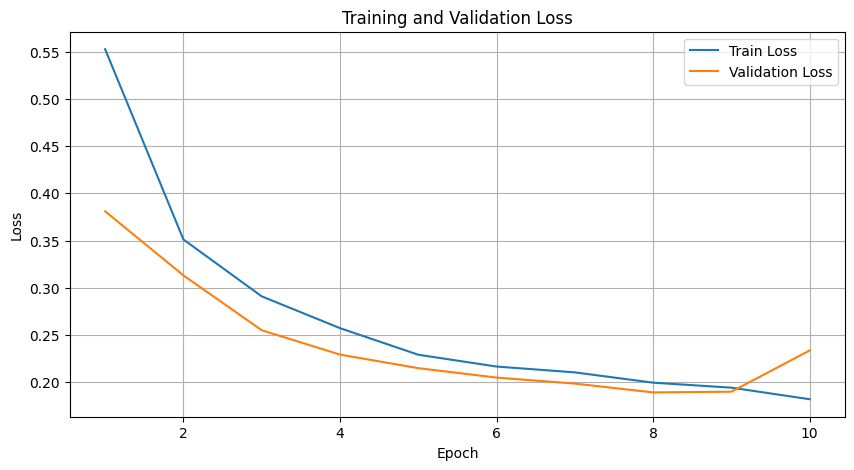

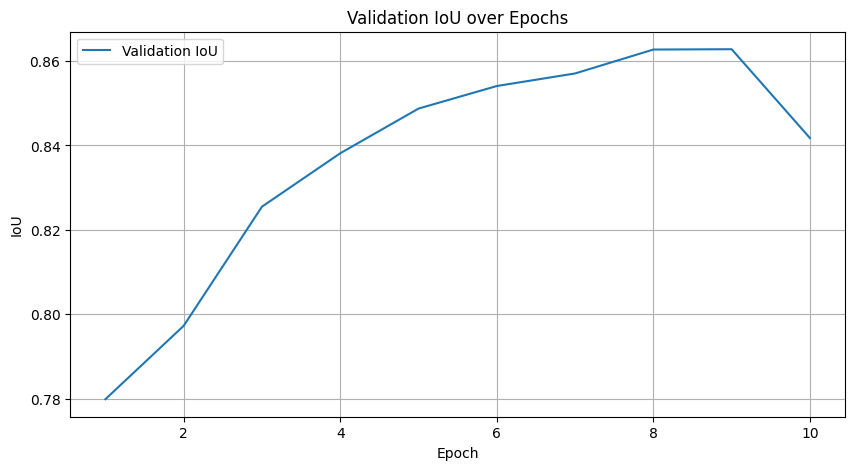

In [10]:
import matplotlib.pyplot as plt

# Plotting loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting IoU
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), val_ious, label='Validation IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.title('Validation IoU over Epochs')
plt.legend()
plt.grid(True)
plt.show()

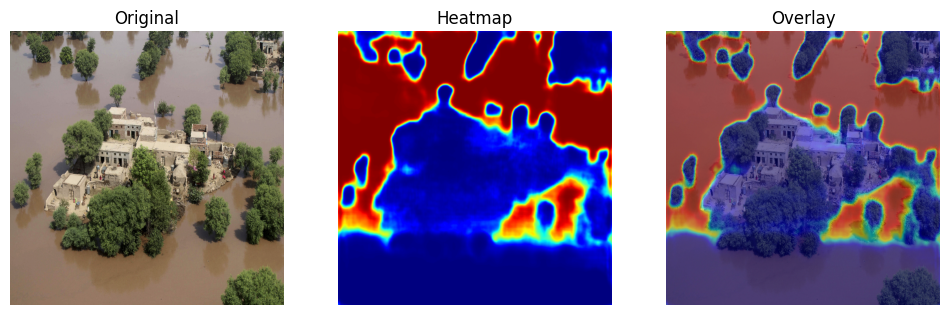

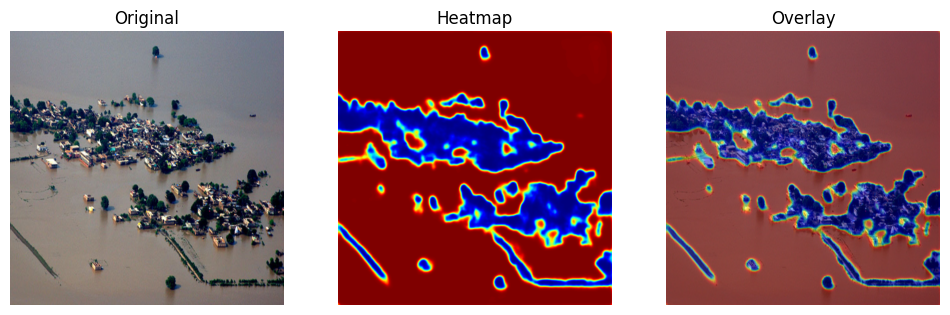

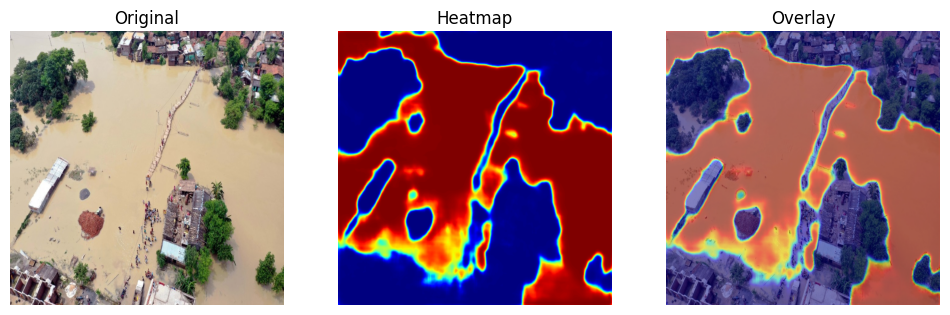

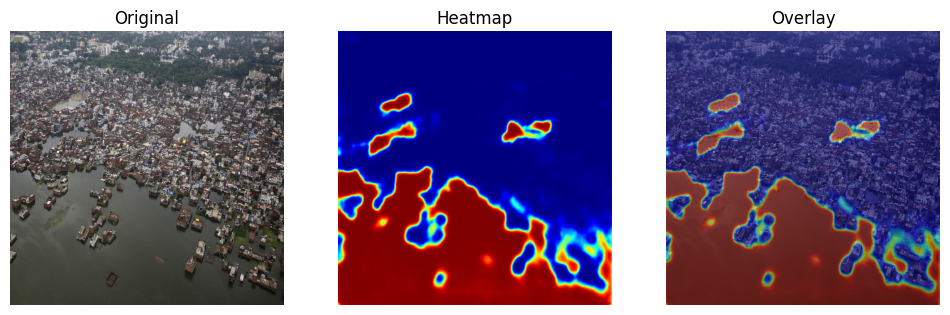

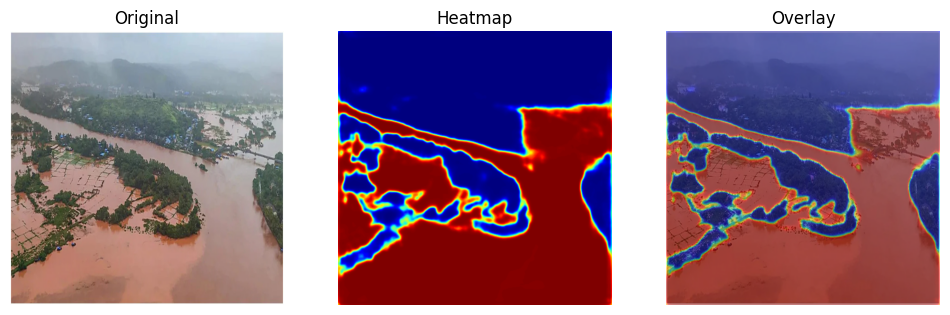

In [11]:
import matplotlib.pyplot as plt, glob, cv2, numpy as np
model.load_state_dict(torch.load("best_unet.pth",map_location=device))
model.eval()

def show_pred(img_path,thr=0.5,alpha=0.5):
    img=cv2.cvtColor(cv2.imread(img_path),cv2.COLOR_BGR2RGB)
    h,w=img.shape[:2]
    aug=val_tfms(image=img)
    x=aug["image"].unsqueeze(0).to(device)
    with torch.no_grad():
        pred=torch.sigmoid(model(x))[0][0].cpu().numpy()
    pred_resized=cv2.resize(pred,(w,h))
    heatmap=(pred_resized*255).astype(np.uint8)
    heatmap=cv2.applyColorMap(heatmap,cv2.COLORMAP_JET)
    heatmap=cv2.cvtColor(heatmap,cv2.COLOR_BGR2RGB)
    overlay=cv2.addWeighted(img,1-alpha,heatmap,alpha,0)
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1);plt.imshow(img);plt.title("Original");plt.axis('off')
    plt.subplot(1,3,2);plt.imshow(pred_resized,cmap='jet');plt.title("Heatmap");plt.axis('off')
    plt.subplot(1,3,3);plt.imshow(overlay);plt.title("Overlay");plt.axis('off')
    plt.show()

sample=sorted(glob.glob(f"{BASE}/test/images/*"))[:5]
for s in sample: show_pred(s)


In [12]:
import torch
from tqdm import tqdm

model.load_state_dict(torch.load("best_unet.pth", map_location=device))
model.eval()

# 2. test dataloader
test_dl = DataLoader(test_ds, batch_size=8, shuffle=False, num_workers=2, pin_memory=True)

# 3. Run the evaluation loop
total_test_iou = 0.0
test_progress_bar = tqdm(test_dl, desc="Evaluating on Test Set")

with torch.no_grad():
    for x, y in test_progress_bar:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        iou = iou_pytorch(pred, y) # Reusing your IoU function
        total_test_iou += iou.item()

# 4. Calculate and print the final average IoU
avg_test_iou = total_test_iou / len(test_dl)

print("\n--- Testing Complete ---")
print(f"Final Average IoU on the Test Set: {avg_test_iou:.4f}")

Evaluating on Test Set: 100%|██████████| 43/43 [00:05<00:00,  8.08it/s]


--- Testing Complete ---
Final Average IoU on the Test Set: 0.8639


In [13]:
!pip install streamlit -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 71.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 102.0 MB/s eta 0:00:00


In [14]:
# app.py
%%writefile app.py
import streamlit as st
import torch
import cv2
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp

# --- CONFIGURATION ---
st.set_page_config(layout="wide", page_title="Flood Mapping AI")
st.title("🌊 AI-Powered Flood Mapping Tool")
st.write("Upload a satellite or aerial image to detect and visualize flooded areas.")

# --- MODEL AND TRANSFORMS (Copy from your training script) ---
DEVICE = torch.device("cpu") # Use CPU for deployment
IMG_SIZE = 256
VAL_TFMS = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

@st.cache_resource # Cache the model for faster re-runs
def load_model():
    model = smp.Unet(encoder_name="resnet34", in_channels=3, classes=1)
    model.load_state_dict(torch.load("best_unet.pth", map_location=DEVICE))
    model.eval()
    return model

model = load_model()

# --- PREDICTION AND VISUALIZATION FUNCTION ---
def predict_and_visualize(image_bytes, alpha=0.5):
    # Load image
    nparr = np.frombuffer(image_bytes, np.uint8)
    img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]

    # Preprocess and predict
    aug = VAL_TFMS(image=img)
    x = aug["image"].unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        pred = torch.sigmoid(model(x))[0][0].cpu().numpy()

    # Resize prediction to original image size
    pred_resized = cv2.resize(pred, (w, h))

    # Create heatmap
    heatmap = (pred_resized * 255).astype(np.uint8)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)

    # Create overlay
    overlay = cv2.addWeighted(img, 1 - alpha, heatmap_color, alpha, 0)

    return img, heatmap_color, overlay

# --- STREAMLIT UI ---
uploaded_file = st.file_uploader("Choose an image...", type=["jpg", "jpeg", "png"])
overlay_alpha = st.slider("Overlay Transparency", 0.0, 1.0, 0.5, 0.05)

if uploaded_file is not None:
    st.info("Processing image... Please wait.")
    original, heatmap, overlay = predict_and_visualize(uploaded_file.getvalue(), overlay_alpha)

    st.success("Processing complete!")
    col1, col2, col3 = st.columns(3)
    with col1:
        st.image(original, caption="Original Image", use_column_width=True)
    with col2:
        st.image(heatmap, caption="Flood Heatmap", use_column_width=True)
    with col3:
        st.image(overlay, caption="Overlay", use_column_width=True)

Writing app.py


In [15]:
!pip freeze > requirements.txt